# Introduction/Purpose

The most common cancer in the United States is skin cancer, with a prevalence of 20% by the age of 70. Early detection is essential for prompt treatment and survival. A model to predict malignant skin cancer from at-home images can accelerate the process of seeking medical support.

### Import Libraries

In [1]:
# Standard
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch/torchvision
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

### Load + Wrangle Data

In [2]:
# Image preprocessing; resize to 224 x 224 pixels, convert image to PyTorch tensor, normalize pixel values

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
])

##### Load first image dataset

In [3]:
# Load data, assign labels from folder names, transform images

data_dir = './Malignant_vs_Benign_Skin_Cancer/Data - Unsplit'

dataset1 = datasets.ImageFolder(root=data_dir, transform=transform)

In [4]:
# Split into train and test sets

val_split = 0.2
total_size = len(dataset1)
val_size = int(val_split * total_size)
train_size = total_size - val_size

torch.manual_seed(42) 
train_dataset1, val_dataset1 = random_split(dataset1, [train_size, val_size])

##### Load second image dataset

In [5]:
# Map labels from .csv file to images

from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
])

class CustomImageDataset(Dataset):
    # Initialize dataset
    def __init__(self, img_dir, label_file, transform=transform):
        self.img_dir = img_dir
        self.transform = transform
        self.labels_df = pd.read_csv(label_file)
        self.labels_df.columns = self.labels_df.columns.str.strip().str.lower()

    # Number of samples in dataset
    def __len__(self):
        return len(self.labels_df)

    # Returns one image/label at a time; required by all PyTorch Dataset objects
    def __getitem__(self, idx):
        row = self.labels_df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image_id'] + '.jpg')

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"File not found: {img_path}")
        
        temp_label = row['dx'] 
        if temp_label in ['akiec', 'bcc', 'mel']:
            label = 'malignant'
        else:
            label = 'benign'

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
# Create dataset labels

dataset2 = CustomImageDataset(
    img_dir=r'.\Skin Cancer MNIST HAM10000\Images', 
    label_file=r'.\Skin Cancer MNIST HAM10000\Original Data\HAM10000_metadata.csv', 
    transform=transform
)

In [7]:
# Split into train and test sets

val_split = 0.2
total_size = len(dataset2)
val_size = int(val_split * total_size)
train_size = total_size - val_size

torch.manual_seed(42) 
train_dataset2, val_dataset2 = random_split(dataset2, [train_size, val_size])

##### Concatenate datasets, create DataLoaders

In [8]:
# Concatenate datasets

from torch.utils.data import ConcatDataset

merged_train_dataset = ConcatDataset([train_dataset1, train_dataset2])
merged_val_dataset = ConcatDataset([val_dataset1, val_dataset2])

In [9]:
# Create DataLoaders to feed data into model during training

train_loader = DataLoader(merged_train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(merged_val_dataset, batch_size=32, shuffle=False)

### EDA

*Are the classes balanced?*

Dataset 1:
Benign: 1800 images
Malignant: 1497 images
Approximately balanced

Dataset 2:


In [10]:
labels_df = pd.read_csv(r'.\Skin Cancer MNIST HAM10000\Original Data\HAM10000_metadata.csv')

In [11]:
labels_df.columns = labels_df.columns.str.strip().str.lower()

In [12]:
labels_df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

In [13]:
malignant_labels = ['akiec', 'bcc', 'mel']

In [14]:
# Count images
malignant_count = labels_df['dx'].isin(malignant_labels).sum()
benign_count = len(labels_df) - malignant_count

print(f"Malignant images: {malignant_count}")
print(f"Benign images: {benign_count}")

Malignant images: 1954
Benign images: 8061


In [15]:
print(f"Malignant %: {(malignant_count/(malignant_count+benign_count))*100:.2f}%")

Malignant %: 19.51%


Class imbalance in 2nd dataset

In [16]:
print(f"Malignant % in combined dataset: {((1497+malignant_count)/(1800+1497+malignant_count+benign_count))*100:.2f}%")

Malignant % in combined dataset: 25.92%


Mild class imbalance in overall dataset; to be accounted for in upcoming steps

[Class imbalance % criteria](https://developers.google.com/machine-learning/crash-course/overfitting/imbalanced-datasets)

*Do the images contain enough variety?*


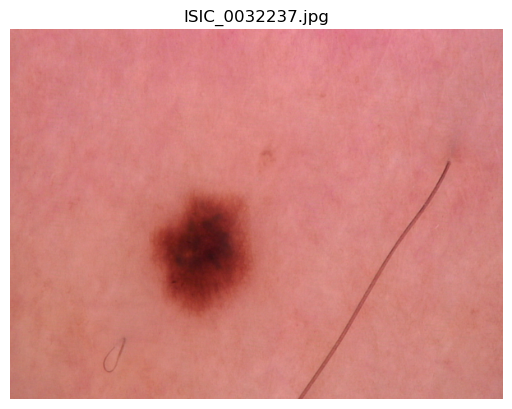

In [23]:
import random

image_files = labels_df['image_id']

random_img = random.choice(image_files)+'.jpg'
img_path = os.path.join(r'.\Skin Cancer MNIST HAM10000\Images', random_img)

# Display random image
image = Image.open(img_path)
plt.imshow(image)
plt.title(random_img)
plt.axis("off")
plt.show()

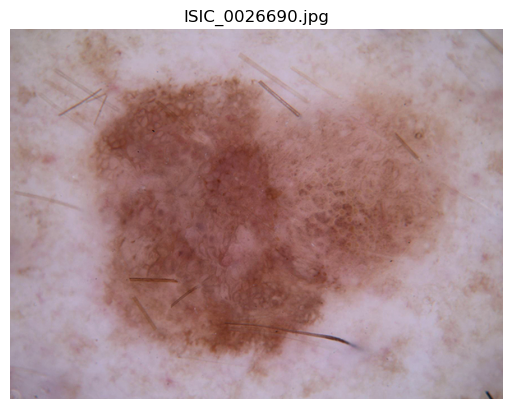

In [34]:
random_img = random.choice(image_files)+'.jpg'
img_path = os.path.join(r'.\Skin Cancer MNIST HAM10000\Images', random_img)
image = Image.open(img_path)
plt.imshow(image)
plt.title(random_img)
plt.axis("off")
plt.show()

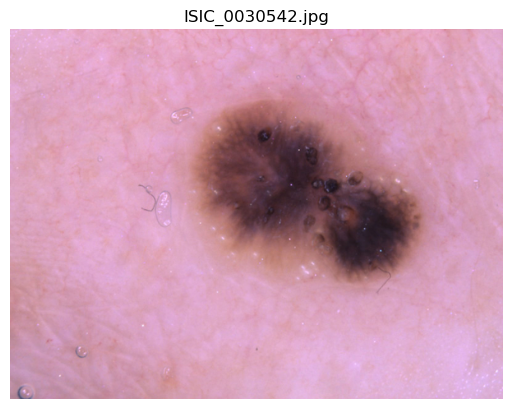

In [35]:
random_img = random.choice(image_files)+'.jpg'
img_path = os.path.join(r'.\Skin Cancer MNIST HAM10000\Images', random_img)
image = Image.open(img_path)
plt.imshow(image)
plt.title(random_img)
plt.axis("off")
plt.show()

Both datasets show wide variety in shape, color, and appearance/no appearance of hair. However, there is less variety in skin tone and the model may not generalize well to those with darker skin tones.

*Image formats and resolutions*

Images resized in Data Wrangling step; all images are .jpg